In [ ]:
import pandas as pd
import numpy as np
import random

# Number of records (increase for larger dataset)
num_records = 100000

# Generate timestamps
timestamps = pd.date_range("2025-01-01", periods=num_records, freq="1T")

# Possible failure types with probabilities (85% normal, 15% failure cases)
failure_types = ['None', 'Node Failure', 'Resource Exhaustion', 'Network Issue', 'Service Disruption']
failure_probs = [0.85, 0.05, 0.05, 0.03, 0.02]

# Define realistic resource usage ranges based on failure types
def generate_metrics(failure_type):
    if failure_type == 'None':
        return (
            np.random.uniform(10, 60),  # CPU Usage (low to moderate)
            np.random.uniform(20, 70),  # Memory Usage
            np.random.uniform(500, 5000),  # Network IO
            np.random.uniform(10, 70),  # Disk Usage
            np.random.uniform(1, 50)  # Network Latency (low)
        )
    elif failure_type == 'Node Failure':
        return (
            np.random.uniform(90, 100),  # CPU Usage spikes
            np.random.uniform(85, 100),  # Memory Usage maxed out
            np.random.uniform(100, 1000),  # Low Network IO due to node failure
            np.random.uniform(90, 100),  # High Disk Usage
            np.random.uniform(100, 500)  # High Network Latency
        )
    elif failure_type == 'Resource Exhaustion':
        return (
            np.random.uniform(95, 100),  # CPU Usage at peak
            np.random.uniform(95, 100),  # Memory fully used
            np.random.uniform(5000, 10000),  # High Network IO due to stress
            np.random.uniform(95, 100),  # Disk at full capacity
            np.random.uniform(50, 150)  # Medium Latency
        )
    elif failure_type == 'Network Issue':
        return (
            np.random.uniform(30, 70),  # Moderate CPU
            np.random.uniform(40, 80),  # Moderate Memory
            np.random.uniform(100, 500),  # Low Network IO due to issues
            np.random.uniform(40, 80),  # Disk usage normal
            np.random.uniform(300, 1000)  # Very high Network Latency
        )
    else:  # Service Disruption
        return (
            np.random.uniform(50, 90),  # CPU fluctuates
            np.random.uniform(60, 90),  # Memory Usage unstable
            np.random.uniform(500, 5000),  # Moderate Network IO
            np.random.uniform(60, 90),  # Disk Usage moderate
            np.random.uniform(100, 500)  # High Latency
        )

# Generate the dataset
data = []
for i in range(num_records):
    failure_type = np.random.choice(failure_types, p=failure_probs)
    cpu_usage, memory_usage, network_io, disk_usage, network_latency = generate_metrics(failure_type)

    data.append([
        timestamps[i],
        cpu_usage,
        memory_usage,
        network_io,
        disk_usage,
        network_latency,
        np.random.choice(['Running', 'Pending', 'CrashLoopBackOff', 'Failed'], p=[0.85, 0.05, 0.05, 0.05]),  # Pod Status
        np.random.choice(['Healthy', 'Unhealthy'], p=[0.9, 0.1]),  # Node Status
        failure_type
    ])

# Convert to DataFrame
df = pd.DataFrame(data, columns=[
    'timestamp', 'cpu_usage', 'memory_usage', 'network_io', 'disk_usage', 'network_latency',
    'pod_status', 'node_status', 'failure_type'
])

# Save as CSV
csv_filename = "simulated_k8s_dataset.csv"
df.to_csv(csv_filename, index=False)

print(f"Dataset successfully generated and saved as {csv_filename}")
print(df.head())


<ipython-input-1-1b1fa2736dee>:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range("2025-01-01", periods=num_records, freq="1T")


Dataset successfully generated and saved as simulated_k8s_dataset.csv
            timestamp  cpu_usage  memory_usage   network_io  disk_usage  \
0 2025-01-01 00:00:00  56.612394     57.479521  1082.602748   36.570694   
1 2025-01-01 00:01:00  52.397368     40.399114   978.800233   56.948527   
2 2025-01-01 00:02:00  46.338073     58.879278  1809.952856   48.601113   
3 2025-01-01 00:03:00  73.918552     66.613573   503.320385   86.290303   
4 2025-01-01 00:04:00  30.173780     34.662327  4296.702776   63.534344   

   network_latency pod_status node_status        failure_type  
0        14.252444     Failed     Healthy                None  
1         3.874663    Running   Unhealthy                None  
2        29.934146    Running   Unhealthy                None  
3       495.118771    Running     Healthy  Service Disruption  
4        42.290714    Running     Healthy                None  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv("simulated_k8s_dataset.csv")

print("First 5 rows of the dataset:")
print(df.head())

# Step 1: Handle Missing Values (if any)
print("\nMissing values before handling:")
print(df.isnull().sum())

# Fill missing values with appropriate strategies
df['cpu_usage'].fillna(df['cpu_usage'].mean(), inplace=True)
df['memory_usage'].fillna(df['memory_usage'].mean(), inplace=True)
df['network_io'].fillna(df['network_io'].mean(), inplace=True)
df['disk_usage'].fillna(df['disk_usage'].mean(), inplace=True)
df['network_latency'].fillna(df['network_latency'].mean(), inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())

# Step 2: Convert Timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df.drop('timestamp', axis=1, inplace=True)

# Step 3: Encode Categorical Columns
label_encoder = LabelEncoder()
df['pod_status'] = label_encoder.fit_transform(df['pod_status'])
df['node_status'] = label_encoder.fit_transform(df['node_status'])
df['failure_type'] = label_encoder.fit_transform(df['failure_type'])

# Step 4: Normalize Numerical Columns
scaler = StandardScaler()
numerical_cols = ['cpu_usage', 'memory_usage', 'network_io', 'disk_usage', 'network_latency', 'hour', 'day_of_week']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nData after preprocessing:")
print(df.head())

# Step 5: Split Data into Features and Target
X = df.drop('failure_type', axis=1)
y = df['failure_type']

# Split into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData Split Complete!")
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


First 5 rows of the dataset:
             timestamp  cpu_usage  memory_usage   network_io  disk_usage  \
0  2025-01-01 00:00:00  56.612394     57.479521  1082.602748   36.570694   
1  2025-01-01 00:01:00  52.397368     40.399114   978.800233   56.948527   
2  2025-01-01 00:02:00  46.338073     58.879278  1809.952856   48.601113   
3  2025-01-01 00:03:00  73.918552     66.613573   503.320385   86.290303   
4  2025-01-01 00:04:00  30.173780     34.662327  4296.702776   63.534344   

   network_latency pod_status node_status        failure_type  
0        14.252444     Failed     Healthy                 NaN  
1         3.874663    Running   Unhealthy                 NaN  
2        29.934146    Running   Unhealthy                 NaN  
3       495.118771    Running     Healthy  Service Disruption  
4        42.290714    Running     Healthy                 NaN  

Missing values before handling:
timestamp              0
cpu_usage              0
memory_usage           0
network_io            

<ipython-input-2-9ee0b0866eea>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cpu_usage'].fillna(df['cpu_usage'].mean(), inplace=True)
<ipython-input-2-9ee0b0866eea>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import pandas as pd

# Load the dataset
df = pd.read_csv("simulated_k8s_dataset.csv")

# Step 1: Handle Missing Values
# Fill numeric columns with mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.mean()))

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

print("Missing values after handling:")
print(df.isnull().sum())


# Step 2: Convert Timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df.drop('timestamp', axis=1, inplace=True)

# Step 3: Encode Categorical Columns
label_encoder = LabelEncoder()
for col in ['pod_status', 'node_status', 'failure_type']:
    df[col] = label_encoder.fit_transform(df[col])

# Step 4: Normalize Numerical Columns
scaler = StandardScaler()
numerical_cols = ['cpu_usage', 'memory_usage', 'network_io', 'disk_usage', 'network_latency', 'hour', 'day_of_week']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Step 5: Apply Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df[numerical_cols])

# Convert anomaly scores (-1 for anomalies, 1 for normal) to 0 and 1
df['anomaly_score'] = df['anomaly_score'].apply(lambda x: 0 if x == 1 else 1)

# Step 6: Prepare Training and Test Data
X = df.drop('failure_type', axis=1)
y = df['failure_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train the Random Forest with Anomaly Score as Feature
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Step 8: Predict and Evaluate
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion Matrix for detailed analysis
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Missing values after handling:
timestamp          0
cpu_usage          0
memory_usage       0
network_io         0
disk_usage         0
network_latency    0
pod_status         0
node_status        0
failure_type       0
dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       607
           1       1.00      1.00      1.00      1052
           2       1.00      1.00      1.00     17942
           3       1.00      1.00      1.00       399

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Accuracy Score: 1.0
Confusion Matrix:
 [[  607     0     0     0]
 [    0  1052     0     0]
 [    0     0 17942     0]
 [    0     0     0   399]]


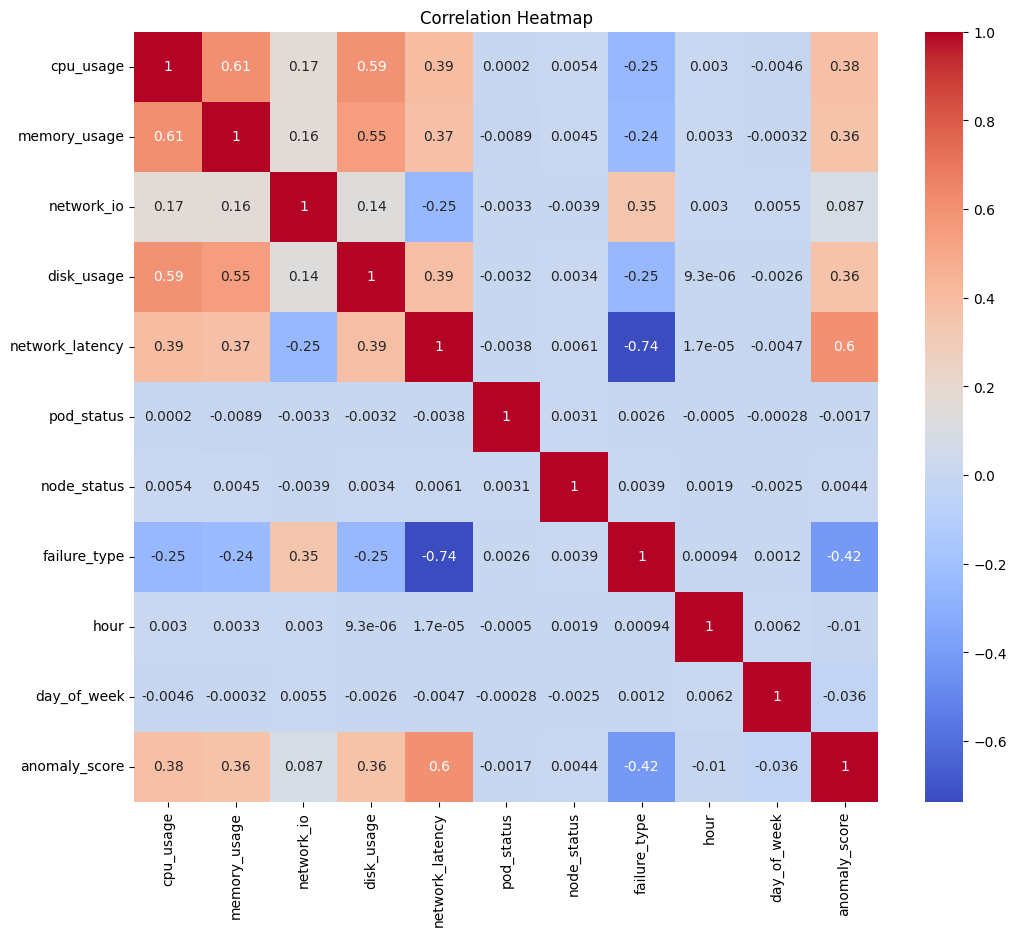

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
from imblearn.over_sampling import SMOTE

# Separate features and labels
X = df.drop('failure_type', axis=1)
y = df['failure_type']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Resampled class distribution: {y_resampled.value_counts()}")


Resampled class distribution: failure_type
2    90064
3    90064
0    90064
1    90064
Name: count, dtype: int64
